In [48]:
import pandas
from transformers import BertTokenizer
import pickle
from trainer import Classifier
import torch
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt


In [3]:
checkpoint = 'bert-base-multilingual-cased'

In [4]:
tokenizer = BertTokenizer.from_pretrained(checkpoint)

In [5]:
en_test = pickle.load(open('../data/en_test.p', 'rb'))
hi_test = pickle.load(open('../data/hi_test.p', 'rb'))

In [6]:
EN_EXAMPLES = len(en_test['class'])
HI_EXAMPLES = len(hi_test['class'])
print(EN_EXAMPLES, HI_EXAMPLES)

1562 385


In [7]:
mbert = Classifier(checkpoint)
mbert.load_state_dict(torch.load('../saved_models/bert-base-multilingual-cased-64.94.pt'))

<All keys matched successfully>

In [8]:
output = tokenizer.batch_encode_plus(
    en_test['post_tokens'],
        add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)
en_input_ids = output['input_ids']
en_attention_mask = output['attention_mask']

output = tokenizer.batch_encode_plus(
    hi_test['post_tokens'],
        add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)
hi_input_ids = output['input_ids']
hi_attention_mask = output['attention_mask']

In [41]:
en_out = []
batch = 16
for i in tqdm(range(0, EN_EXAMPLES, batch)):
    en_prob = mbert.predict_prob(en_input_ids[i:i+batch], en_attention_mask[i:i+batch])
    en_out.extend(en_prob)

  0%|          | 0/98 [00:00<?, ?it/s]

In [51]:
pred = torch.argmax(torch.stack(en_out).to('cpu'), axis=1)
conf_matrix = confusion_matrix(en_test['class'], pred)

In [56]:
def evaluate(conf_matrix, label, pred):
    plt.figure(figsize=(10,8))
    categories = [
        'hate_speech',
        'normal',
        'offensive'
    ]
    sns.heatmap(
        conf_matrix/np.sum(conf_matrix, axis=1), 
        annot=True, 
        fmt='.2%', 
        cmap='Blues',
        xticklabels=categories,
        yticklabels=categories
    )

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()
    print("F1 score:- ", f1_score(label, pred, average="weighted"))

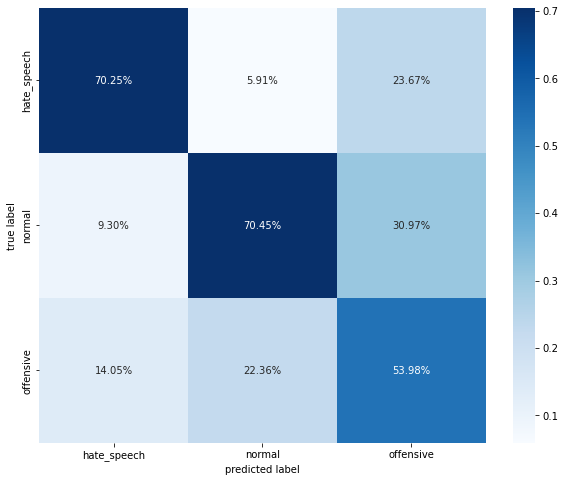

F1 score:-  0.6587666328512324


In [57]:
evaluate(conf_matrix, en_test['class'], pred)

In [44]:
hi_out = []
batch = 16
for i in tqdm(range(0, HI_EXAMPLES, batch)):
    hi_prob = mbert.predict_prob(hi_input_ids[i:i+batch], hi_attention_mask[i:i+batch])
    hi_out.extend(hi_prob)

  0%|          | 0/25 [00:00<?, ?it/s]

In [59]:
pred = torch.argmax(torch.stack(hi_out).to('cpu'), axis=1)
conf_matrix = confusion_matrix(hi_test['class'], pred)

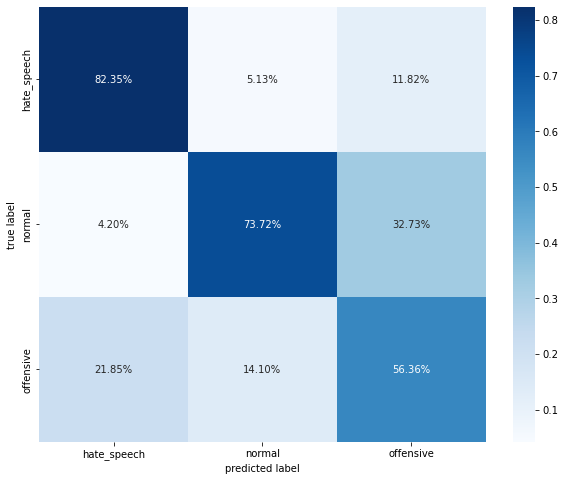

F1 score:-  0.7142090958900204


In [60]:
evaluate(conf_matrix, hi_test['class'], pred)